In [ ]:
import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split

from text_models import TextClassifier, extract_text_blocks, tokenize_data, load_glove_embedding
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

import sys

def progress_bar(i, count):
    size = 40
    x = int(round(size*i/count))
    text = '\rStatus: [%s] %d/%d ' % ("#"*x + "."*(size-x), i, count)
    sys.stdout.write(text)
    sys.stdout.flush()

# Load Dataset 

The dataset is a pandas dataframe with two columns: Text labels and the text sentences and sub-sentences. There are 8 different categories(labels) in total. Each sentence could also have multiple categories(labels) associated with it.

In [3]:
df = pickle.load( open( "gdr_assignment_labelled.pkl", "rb" ))

In [4]:
df.tail

<bound method NDFrame.tail of                                                    label  \
16                            [Job Security/Advancement]   
149    [Job Security/Advancement, business_vision_com...   
220                           [Job Security/Advancement]   
233                           [Job Security/Advancement]   
396                           [Job Security/Advancement]   
...                                                  ...   
48187                           [wlb_working_conditions]   
48198                           [wlb_working_conditions]   
48201                           [wlb_working_conditions]   
48218                           [wlb_working_conditions]   
48290                           [wlb_working_conditions]   

                                   pp_sent  
16                  developing your skills  
149                        rapidly growing  
220      easy to get your foot in the door  
233            opportunity for advancement  
396                  car

# Train LSTM

Train a Multilabel text classifier using LSTM. This model has the following architecture: <br>
Input -> Word Embedding Layer -> LSTM -> Spatial Dropout -> Fully Connected -> RELU -> Fully Connected -> Sigmoid <br>
Here the LSTM output to the next fully connected layer is from the last time step only. All the model implementations could be found at text_models.py

In [17]:
X, y, tokenizer, label_index = tokenize_data(df['pp_sent'].values, df['label'])
model_lstm = TextClassifier(tokenizer, label_index)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

history_lstm = model_lstm.train(X_train, y_train, 'LSTM')
model_lstm.model.summary()

Shape of data tensor: (8000,)
Found 3796 unique tokens.
Train on 4824 samples, validate on 536 samples
Epoch 1/5
4824/4824 [==============================] - 85s 18ms/sample - loss: 0.4466 - categorical_accuracy: 0.1451 - val_loss: 0.3854 - val_categorical_accuracy: 0.1399
Epoch 2/5
4824/4824 [==============================] - 74s 15ms/sample - loss: 0.3711 - categorical_accuracy: 0.2991 - val_loss: 0.3281 - val_categorical_accuracy: 0.5168
Epoch 3/5
4824/4824 [==============================] - 68s 14ms/sample - loss: 0.2871 - categorical_accuracy: 0.5529 - val_loss: 0.2296 - val_categorical_accuracy: 0.6810
Epoch 4/5
4824/4824 [==============================] - 67s 14ms/sample - loss: 0.1936 - categorical_accuracy: 0.7396 - val_loss: 0.1517 - val_categorical_accuracy: 0.7966
Epoch 5/5
4824/4824 [==============================] - 66s 14ms/sample - loss: 0.1284 - categorical_accuracy: 0.8422 - val_loss: 0.1071 - val_categorical_accuracy: 0.8825
Model: "sequential_100"
__________________

Evaluate Model

In [18]:
test_loss, test_acc = model_lstm.evaluate(X_test,y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

2640/2640 [==============================] - 14s 5ms/sample - loss: 0.1191 - categorical_accuracy: 0.8644
Test Loss: 0.11905744423468907
Test Accuracy: 0.864393949508667


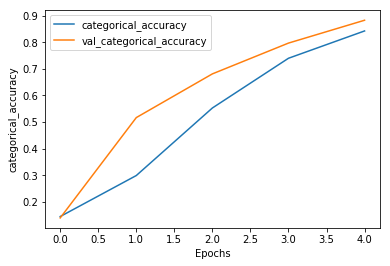

In [19]:
plot_graphs(history_lstm, 'categorical_accuracy')

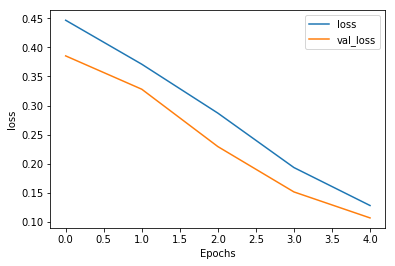

In [20]:
plot_graphs(history_lstm, 'loss')

# Train CNN

Model Architecture: <br> Input -> Word Embedding Layer -> Convolution Layer -> RELU -> Global Max Pool -> Fully Connected -> Sigmoid 

In [21]:
X, y, tokenizer, label_index = tokenize_data(df['pp_sent'].values, df['label'])
model_cnn = TextClassifier(tokenizer, label_index)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

history_cnn = model_cnn.train(X_train, y_train, 'CNN')
model_cnn.model.summary()

Shape of data tensor: (8000,)
Found 3796 unique tokens.
Train on 4824 samples, validate on 536 samples
Epoch 1/5
4824/4824 [==============================] - 4s 855us/sample - loss: 0.4458 - categorical_accuracy: 0.2463 - val_loss: 0.3470 - val_categorical_accuracy: 0.6698
Epoch 2/5
4824/4824 [==============================] - 4s 789us/sample - loss: 0.2397 - categorical_accuracy: 0.8022 - val_loss: 0.1207 - val_categorical_accuracy: 0.8899
Epoch 3/5
4824/4824 [==============================] - 3s 725us/sample - loss: 0.0700 - categorical_accuracy: 0.9231 - val_loss: 0.0494 - val_categorical_accuracy: 0.9496
Epoch 4/5
4824/4824 [==============================] - 4s 766us/sample - loss: 0.0295 - categorical_accuracy: 0.9525 - val_loss: 0.0334 - val_categorical_accuracy: 0.9534
Epoch 5/5
4824/4824 [==============================] - 4s 760us/sample - loss: 0.0159 - categorical_accuracy: 0.9639 - val_loss: 0.0276 - val_categorical_accuracy: 0.9664
Model: "sequential_101"
__________________

Evaluate CNN Model

In [22]:
test_loss, test_acc = model_cnn.evaluate(X_test,y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

2640/2640 [==============================] - 0s 189us/sample - loss: 0.0283 - categorical_accuracy: 0.9534
Test Loss: 0.028260806451241176
Test Accuracy: 0.9534090757369995


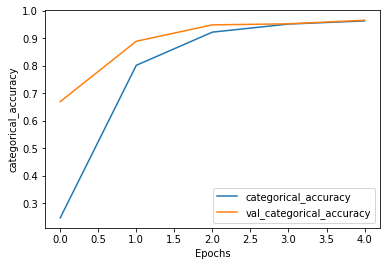

In [23]:
plot_graphs(history_cnn, 'categorical_accuracy')

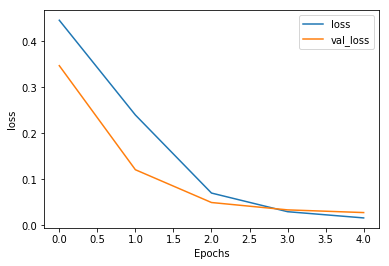

In [24]:
plot_graphs(history_cnn, 'loss')

# Train CNN Glove

Model Architecture: 
Input -> GLoVe Word Embedding(Non trainable)  -> Convolution Layer -> RELU -> Global Max Pool -> Fully Connected -> Sigmoid

In [25]:
X, y, tokenizer, label_index = tokenize_data(df['pp_sent'].values, df['label'])
model_cnn_glove = TextClassifier(tokenizer, label_index)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

history_cnn_glove = model_cnn_glove.train(X_train, y_train, 'CNN_Glove')
model_cnn_glove.model.summary()

Shape of data tensor: (8000,)
Found 3796 unique tokens.
Train on 4824 samples, validate on 536 samples
Epoch 1/5
4824/4824 [==============================] - 4s 812us/sample - loss: 0.2958 - categorical_accuracy: 0.6561 - val_loss: 0.1637 - val_categorical_accuracy: 0.8526
Epoch 2/5
4824/4824 [==============================] - 3s 719us/sample - loss: 0.1249 - categorical_accuracy: 0.8663 - val_loss: 0.1016 - val_categorical_accuracy: 0.8993
Epoch 3/5
4824/4824 [==============================] - 3s 690us/sample - loss: 0.0812 - categorical_accuracy: 0.9078 - val_loss: 0.0794 - val_categorical_accuracy: 0.9123
Epoch 4/5
4824/4824 [==============================] - 3s 725us/sample - loss: 0.0585 - categorical_accuracy: 0.9314 - val_loss: 0.0649 - val_categorical_accuracy: 0.9291
Epoch 5/5
4824/4824 [==============================] - 3s 706us/sample - loss: 0.0441 - categorical_accuracy: 0.9505 - val_loss: 0.0579 - val_categorical_accuracy: 0.9272
Model: "sequential_102"
__________________

Evaluate Glove Model

In [26]:
test_loss, test_acc = model_cnn_glove.evaluate(X_test,y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

2640/2640 [==============================] - 1s 219us/sample - loss: 0.0628 - categorical_accuracy: 0.9140
Test Loss: 0.0628296746449037
Test Accuracy: 0.9140151739120483


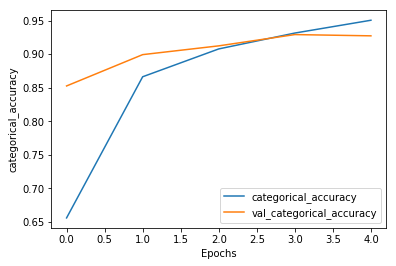

In [27]:
plot_graphs(history_cnn_glove, 'categorical_accuracy')

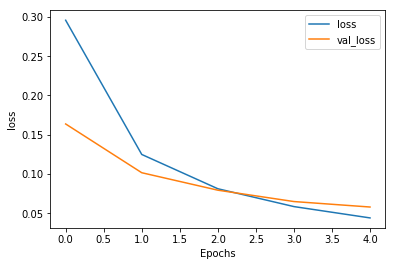

In [28]:
plot_graphs(history_cnn_glove, 'loss')

# Train MLP

Model Architecture: <br>
Input -> Word Embedding Layer -> 4x(Fully Connected -> RELU) -> Fully Connected -> Sigmoid <br>

In [29]:
X, y, tokenizer, label_index = tokenize_data(df['pp_sent'].values, df['label'])
model_mlp = TextClassifier(tokenizer, label_index)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

history_mlp = model_mlp.train(X_train, y_train, 'MLP')
model_mlp.model.summary()

Shape of data tensor: (8000,)
Found 3796 unique tokens.
Train on 4824 samples, validate on 536 samples
Epoch 1/5
4824/4824 [==============================] - 2s 515us/sample - loss: 3.1433 - categorical_accuracy: 0.1231 - val_loss: 1.0167 - val_categorical_accuracy: 0.1399
Epoch 2/5
4824/4824 [==============================] - 2s 384us/sample - loss: 1.0423 - categorical_accuracy: 0.1350 - val_loss: 0.8477 - val_categorical_accuracy: 0.1362
Epoch 3/5
4824/4824 [==============================] - 2s 338us/sample - loss: 0.8367 - categorical_accuracy: 0.1457 - val_loss: 0.7554 - val_categorical_accuracy: 0.1493
Epoch 4/5
4824/4824 [==============================] - 2s 336us/sample - loss: 0.7199 - categorical_accuracy: 0.1420 - val_loss: 0.6569 - val_categorical_accuracy: 0.1343
Epoch 5/5
4824/4824 [==============================] - 2s 340us/sample - loss: 0.6430 - categorical_accuracy: 0.1439 - val_loss: 0.6100 - val_categorical_accuracy: 0.1381
Model: "sequential_103"
__________________

Evaluate MLP Model

In [30]:
test_loss, test_acc = model_mlp.evaluate(X_test,y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

2640/2640 [==============================] - 0s 111us/sample - loss: 0.6101 - categorical_accuracy: 0.1466
Test Loss: 0.6100886171514338
Test Accuracy: 0.14659090340137482


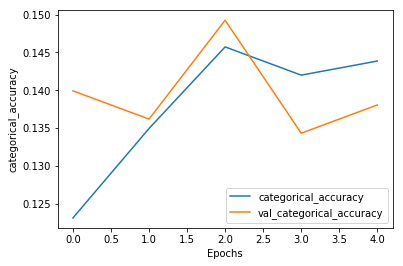

In [31]:
plot_graphs(history_mlp, 'categorical_accuracy')

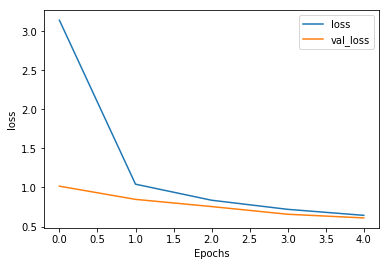

In [32]:
plot_graphs(history_mlp, 'loss')

The cross_validation function iterates over different hyper parameter settings to find the best model configuration.

In [6]:
def cross_validation(model_type, X_train, y_train, tokenizer, label_index):

    learning_rates = np.linspace(1e-3, 5e-4, 5)
    regularization_strengths = np.linspace(0.001, 1.5, 5)

    best_val = -1.
    best_train = -1
    best_model = None
    best_lr = None
    best_reg = None
    progress_counter = 0
    total_tests = learning_rates.shape[0] * regularization_strengths.shape[0]

    print('Cross validation : ', model_type)
    
    for lr in learning_rates:
        for reg in regularization_strengths:
            # Train the network
            model = TextClassifier(tokenizer, label_index, verbose=0)
            history_mlp = model.train(X_train, y_train, model_type, learning_rate=lr, regularization=reg)
            history_mlp.history['categorical_accuracy']
            train_acc_history = history_mlp.history['categorical_accuracy']
            val_acc_history = history_mlp.history['val_categorical_accuracy']
            val_acc = val_acc_history[-1]

            if val_acc > best_val:
                del best_model
                best_val = val_acc
                best_train = train_acc_history[-1]
                best_model = model
                best_lr = lr
                best_reg = reg
                
            progress_counter += 1    
            progress_bar(progress_counter, total_tests)

            #print('lr: %f, reg: %f, t_acc: %f, v_acc: %f.' % (lr, reg,  train_acc_history[-1], val_acc))
    train_acc_history[-1]
    print('Best %s Validation accuracy: %f, Train acc: %f lr: %f, reg: %f' % (model_type, best_val, best_train, best_lr, best_reg) )
    return best_model

In [7]:
X, y, tokenizer, label_index = tokenize_data(df['pp_sent'].values, df['label'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

best_lstm = cross_validation("LSTM", X_train, y_train, tokenizer, label_index)

W0213 18:34:33.207720 4762693056 deprecation.py:506] From /Users/kshitijsharma/Documents/CS231n/assignment2/.env/lib/python3.7/site-packages/tensorflow/python/keras/backend.py:4081: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Shape of data tensor: (8000,)
Found 3796 unique tokens.
Cross validation :  LSTM
Status: [########################################] 25/25 Best LSTM Validation accuracy: 0.917910, Train acc: 0.895315 lr: 0.000875, reg: 1.500000


In [8]:
best_mlp = cross_validation("MLP", X_train, y_train, tokenizer, label_index)
best_cnn = cross_validation("CNN", X_train, y_train, tokenizer, label_index)
best_glove = cross_validation("CNN_Glove", X_train, y_train, tokenizer, label_index)

Cross validation :  MLP
Status: [########################################] 25/25 Best MLP Validation accuracy: 0.214552, Train acc: 0.152363 lr: 0.000875, reg: 1.125250
Cross validation :  CNN
Status: [########################################] 25/25 Best CNN Validation accuracy: 0.962687, Train acc: 0.963723 lr: 0.001000, reg: 0.001000
Cross validation :  CNN_Glove
Status: [########################################] 25/25 Best CNN_Glove Validation accuracy: 0.930970, Train acc: 0.948383 lr: 0.001000, reg: 0.375750


Evaluating Test Accuracies on the best models after cross validation and hyper parameter tuning. 

In [9]:
test_loss, test_acc = best_cnn.evaluate(X_test,y_test)
print('CNN: Test Loss: {}'.format(test_loss))
print('CNN: Test Accuracy: {}'.format(test_acc))

test_loss, test_acc = best_glove.evaluate(X_test,y_test)
print('CNN Glove: Test Loss: {}'.format(test_loss))
print('CNN Glove: Test Accuracy: {}'.format(test_acc))

test_loss, test_acc = best_lstm.evaluate(X_test,y_test)
print('LSTM: Test Loss: {}'.format(test_loss))
print('LSTM: Test Accuracy: {}'.format(test_acc))

test_loss, test_acc = best_mlp.evaluate(X_test,y_test)
print('MLP: Test Loss: {}'.format(test_loss))
print('MLP: Test Accuracy: {}'.format(test_acc))

2640/2640 [==============================] - 1s 206us/sample - loss: 0.0277 - categorical_accuracy: 0.9511
CNN: Test Loss: 0.027716339588391058
CNN: Test Accuracy: 0.9511363506317139
2640/2640 [==============================] - 1s 216us/sample - loss: 0.0620 - categorical_accuracy: 0.9186
CNN Glove: Test Loss: 0.061982240211783036
CNN Glove: Test Accuracy: 0.9185606241226196
2640/2640 [==============================] - 9s 3ms/sample - loss: 0.0872 - categorical_accuracy: 0.8962
LSTM: Test Loss: 0.08724432587623596
LSTM: Test Accuracy: 0.896212100982666
2640/2640 [==============================] - 0s 111us/sample - loss: 0.4230 - categorical_accuracy: 0.1848
MLP: Test Loss: 0.42304272850354513
MLP: Test Accuracy: 0.18484848737716675


The below code block loads a review, splits it into sentences and sub-sentences, and returns a flattened list

In [10]:
data_pros_cons = pickle.load( open( "gdr_assignment_pros_cons.pkl", "rb" ))
review = data_pros_cons.iloc[10,0]
blocks = extract_text_blocks(review)

Text example

In [11]:
print(review)

I worked for the internal marketing team (MarCom) on the creative side. The best thing about working at Apple is your coworkers. They do an excellent job of hiring incredibly intelligent, talented people. It's quite humbling to work alongside such accomplished people. You'll always feel like the dumbest person in the room, which is great because everyone has so much to teach you. Most of them are ego-free (about 70% of them) and will help you whenever possible. There are so many personality types, though nearly all of them are perfectionist Type A people. If that is your kind of crew, you'll do well.

The work usually comes in waves. When you're on, you're all the way on. For weeks at a time you can expect late nights and no weekends. On the flip side, when it's slow, it's very slow. You can often work from home or take comp days. During downtimes it is not uncommon to go in for five hours including a long lunch and then go home.

In addition to this, the compensation is good. The stoc

In [12]:
# Helper function to print sentences and categories from the prediction list
def print_categories_sentences(prediction_dict):
    
    if len(prediction_dict) == 0:
        print ("No predictions made")
        
    for k,v in predictions.items():
        categories = [i[1] for i in v[0]]
        sentence = v[1]
        print(categories, sentence)

# Predict

The predict function takes in a list of important text blocks as input, and returns a list of "useful/important" sentences with their categories and confidence values. <br>
Below we visualize the outputs of the 4 models on the text above(review).

# CNN

In [13]:
predictions = best_cnn.predict(blocks)
print_categories_sentences(predictions)

['Job Security/Advancement'] I worked for the internal marketing team (MarCom) on the creative side.
['culture_team'] They do an excellent job of hiring incredibly intelligent, talented people.
['wlb_working_conditions'] The work usually comes in waves.
['wlb_working_conditions'] For weeks at a time you can expect late nights and no weekends.
['culture_team'] On the flip side, when it's slow, it's very slow.
['wlb_working_conditions'] You can often work from home or take comp days.
['wlb_working_conditions'] During downtimes it is not uncommon to go in for five hours including a long lunch and then go home.
['salary_benefits'] In addition to this, the compensation is good.
['salary_benefits'] The stock program is okay.
['culture_team'] Finally, Tim Cook seems like a genuinely good person.
['culture_team'] Even in the relatively short time he's been in his role, he has made enormous leaps to give that company a real set of values that are current with this generation.


# CNN Glove

In [14]:
predictions = best_glove.predict(blocks)
print_categories_sentences(predictions)

['wlb_working_conditions'] The work usually comes in waves.
['wlb_working_conditions'] For weeks at a time you can expect late nights and no weekends.
['wlb_working_conditions'] You can often work from home or take comp days.
['salary_benefits'] The stock program is okay.
['culture_team'] Finally, Tim Cook seems like a genuinely good person.


# LSTM

In [15]:
predictions = best_lstm.predict(blocks)
print_categories_sentences(predictions)

['culture_team'] The best thing about working at Apple is your coworkers.
['culture_team'] They do an excellent job of hiring incredibly intelligent, talented people.
['culture_team'] Most of them are ego-free (about 70% of them) and will help you whenever possible.
['culture_team'] For weeks at a time you can expect late nights and no weekends.
['wlb_working_conditions'] You can often work from home or take comp days.
['culture_team'] Finally, Tim Cook seems like a genuinely good person.


# MLP

In [16]:
predictions = best_mlp.predict(blocks)
print_categories_sentences(predictions)

No predictions made
